In [1]:
import sys
import os
import numpy as np
# from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import rgb2hex
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # uncomment to run nb from 'pallets/nb'
# sys.path.append(os.path.abspath(os.getcwd()))                    # uncomment to run from project root

from pallets import images as I, datasets as DS, models as M


In [3]:
# Any GPUs available?

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


In [4]:

all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotEncodedImageDataset(mapper, device=device, test_size=0)


### prepare a dataloader

In [5]:
batch_size = 32
num_workers = 0

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
test_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers
)

dataloader = train_loader


In [7]:
img = next(iter(dataset))
print(img.shape)

print(img.shape)
test_img = DS.one_hot_to_rgba(img, mapper)
print(test_img.shape)
test_img = transforms.functional.to_pil_image(test_img)
print(test_img.size)
plt.imshow(test_img)
plt.show()



## simple VAE w/ conv

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    
    # Calculate the output size after the convolutional layers
    def conv_output_size(self, input_size, kernel_size, stride, padding):
        return (input_size - kernel_size + 2 * padding) // stride + 1
        
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.enc_conv1_out_channels = 64
        self.enc_conv2_out_channels = 32
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        self.latent_space_dim = 20

        self.conv1 = nn.Conv2d(222, 
                               self.enc_conv1_out_channels, 
                               kernel_size=self.kernel_size, 
                               stride=self.stride, 
                               padding=self.padding)
        self.conv2 = nn.Conv2d(self.enc_conv1_out_channels, 
                               self.enc_conv2_out_channels, 
                               kernel_size=self.kernel_size, 
                               stride=self.stride, 
                               padding=self.padding)

      

        self.conv1_output_size = self.conv_output_size(24, self.kernel_size, self.stride, self.padding)
        self.conv2_output_size = self.conv_output_size(self.conv1_output_size, 
                                                       self.kernel_size, 
                                                       self.stride, 
                                                       self.padding)

        self.fc_input_features = self.enc_conv2_out_channels * self.conv2_output_size * self.conv2_output_size
        self.fc1 = nn.Linear(self.fc_input_features, 128)
        self.fc_mean = nn.Linear(128, self.latent_space_dim)
        self.fc_logvar = nn.Linear(128, self.latent_space_dim)

        # Decoder
        self.fc3 = nn.Linear(self.latent_space_dim, 128)
        self.fc4 = nn.Linear(128, self.fc_input_features)
        self.conv3 = nn.ConvTranspose2d(self.enc_conv2_out_channels, 
                                        self.enc_conv1_out_channels, 
                                        kernel_size=self.kernel_size, 
                                        stride=self.stride, 
                                        padding=self.padding, 
                                        output_padding=0)
        self.conv4 = nn.ConvTranspose2d(self.enc_conv1_out_channels, 
                                        222, 
                                        kernel_size=self.kernel_size, 
                                        stride=self.stride, 
                                        padding=self.padding, 
                                        output_padding=0)

    def encode(self, x):
        x = F.relu(self.conv1(x))  # Shape: (batch_size, 64, new_height, new_width)
        x = F.relu(self.conv2(x))  # Shape: (batch_size, 32, new_height, new_width)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))    # Shape: (batch_size, 128)
        return self.fc_mean(x), self.fc_logvar(x)  # Shape: (batch_size, 20) each

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))  # Shape: (batch_size, 128)
        z = F.relu(self.fc4(z))  # Shape: (batch_size, self.fc_input_features)
        z = z.view(-1, self.enc_conv2_out_channels, self.conv2_output_size, self.conv2_output_size)  # Reshape to (batch_size, 32, new_height, new_width)
        z = F.relu(self.conv3(z))  # Shape: (batch_size, 64, new_height, new_width)
        z = torch.sigmoid(self.conv4(z))  # Shape: (batch_size, 222, original_height, original_width)
        return z

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar




In [9]:
# Instantiate the model
vae = VAE()

# Example input
input_data = torch.randn(32, 222, 24, 24)  # Batch size 32, 222 channels, 24x24 images

# Forward pass
reconstructed, mean, logvar = vae(input_data)

# Print the shape of the reconstructed output
reconstructed.shape


torch.Size([32, 222, 24, 24])

In [10]:
# JMS Allows putting Loss on GPU

class Loss(nn.Module):
    def forward(self, reconstructed_x, x, mean, logvar):
        # Reconstruction loss (Mean Squared Error)
        recon_loss = F.mse_loss(reconstructed_x, x, reduction='sum')

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return recon_loss + kl_div


vae_loss = Loss().to(device)


In [11]:
import torch.optim as optim


# Instantiate the model
vae = VAE().to(device)  # JMS

# Optimizer (Adam is commonly used)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # If dataloader returns a tuple (images, labels), use data[0] to get the images
        images = data
        optimizer.zero_grad()
        
        # Forward pass: Compute the reconstructed images and the VAE loss
        reconstructed, mean, logvar = vae(images)
        loss = vae_loss(reconstructed, images, mean, logvar)

        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))



In [12]:

# Number of epochs
num_epochs = 15

# Run the training loop
for epoch in range(1, num_epochs + 1):
    train(epoch)


In [13]:
# M.save(vae, 'simplevae.pkl')
# vae = M.load('simplevae.pkl')


In [14]:
# Function to generate a new image from the latent space
def generate_image_from_latent(vae, latent_dim):
    # Sample from the standard normal distribution
    z = torch.randn(1, latent_dim).to(device)
    
    # Run through the decoder
    with torch.no_grad():
        vae.eval()
        generated_image = vae.decode(z)

    return generated_image


# Specify the latent dimension
latent_dim = 20  # Must match the latent dimension size used in the VAE

# Generate the image (assuming the VAE model and latent_dim are already defined)
generated_image = generate_image_from_latent(vae, latent_dim)

# Print the shape to confirm
print(generated_image.shape)
decoded_one_hot= generated_image[0]

print(decoded_one_hot.shape)


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])


In [15]:
# decoded = decoded_one_hot.permute(1, 2, 0)
decoded = decoded_one_hot
print(decoded.shape)
decoded = DS.one_hot_to_rgba(decoded, mapper)
print(decoded.shape)


torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


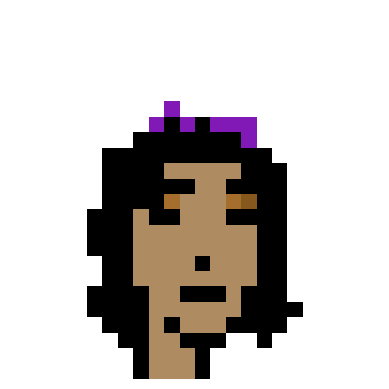

In [16]:
plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


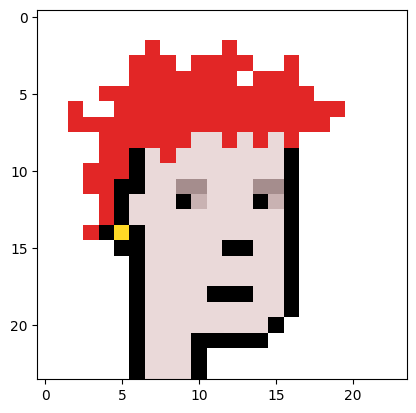

In [17]:
# punk = I.get_punk_tensor(420).permute((1, 2, 0))
punk = I.get_punk_tensor(420)

p = DS.rgba_to_one_hot(punk, mapper)
print(p.shape)

# p = p.permute((1, 2, 0))
# print(p.shape)

p = DS.one_hot_to_rgba(p, mapper)
print(p.shape)

plt.imshow(transforms.functional.to_pil_image(p))
plt.show()



torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


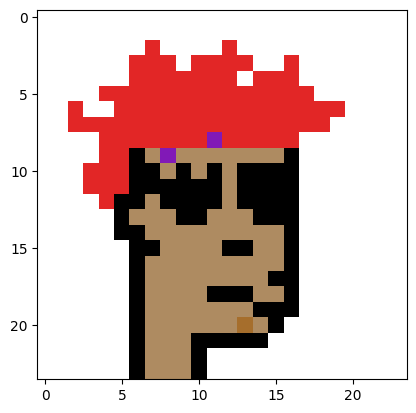

In [19]:
# punk = I.get_punk_tensor(420).permute((1, 2, 0))
punk = I.get_punk_tensor(420)

p = DS.rgba_to_one_hot(punk, mapper)
p = p.unsqueeze(0)
# print(p.shape)

vae.eval()
with torch.no_grad():
    # Encode the input image
    reconstructed, mu, logcar = vae.forward(p.to(device))
    print(reconstructed.shape)


recon_punk = reconstructed[0].cpu()
print(recon_punk.shape)
# recon_punk = recon_punk.permute((1, 2, 0))
# print(recon_punk.shape)

recon_punk = DS.one_hot_to_rgba(recon_punk, mapper)
print(recon_punk.shape)

plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()
